In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np



In [12]:
df = pd.read_excel("lgd_data.xlsx")

In [13]:
df1 = pd.read_excel("lgd_data_deploy.xlsx")

In [14]:
to_fix = [ "Interest Rate (%)", "Income ($)", "Loan to Value Ratio (%)", "Debt to Income Ratio (%)", "LGD%" ]

for col_name in to_fix:
    df[col_name] = df[col_name].astype(str).str.replace(',', '.').astype(float)

numeric_cols_cast = [ "Exposure Amount ($)", "Credit Score", "Loan Term (Months)", "Employment History (Years)", "Previous Defaults" ]
for col_name in numeric_cols_cast:
     df[col_name] = df[col_name].astype(float)

print("Data loaded and cleaned. Info:")
df.info()
print("\nFirst 5 rows:")
print(df.head())

Data loaded and cleaned. Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Exposure Amount ($)         40000 non-null  float64
 1   Credit Score                40000 non-null  float64
 2   Loan Term (Months)          40000 non-null  float64
 3   Interest Rate (%)           40000 non-null  float64
 4   Income ($)                  40000 non-null  float64
 5   Loan to Value Ratio (%)     40000 non-null  float64
 6   Debt to Income Ratio (%)    40000 non-null  float64
 7   Employment History (Years)  40000 non-null  float64
 8   Previous Defaults           40000 non-null  float64
 9   Home Ownership              40000 non-null  object 
 10  Loan Purpose                40000 non-null  object 
 11  Loan Type                   40000 non-null  object 
 12  Region                      40000 non-null  object 
 13  

Feature Engineering using Pandas

In [15]:
# Mean defaults per credit score
df["Defaults_mean_by_Credit_Score"] = df.groupby("Credit Score")["Previous Defaults"].transform('mean')

# Mean income per region
df["Income_mean_by_Region"] = df.groupby("Region")["Income ($)"].transform('mean')

print("\nData after feature engineering:")
print(df[["Credit Score", "Defaults_mean_by_Credit_Score", "Region", "Income_mean_by_Region"]].head())



Data after feature engineering:
   Credit Score  Defaults_mean_by_Credit_Score Region  Income_mean_by_Region
0         729.0                       0.938525  South           60081.187971
1         745.0                       1.022321  South           60081.187971
2         681.0                       1.030303   West           60307.045192
3         684.0                       0.985866   West           60307.045192
4         758.0                       1.046512  North           59985.342548


 Build a Scikit-learn Pipeline and Train the Model

In [16]:
# Define column types
categorical_features = ["Home Ownership", "Loan Purpose", "Loan Type", "Region"]
numeric_features = [
    "Exposure Amount ($)", "Credit Score", "Loan Term (Months)", "Interest Rate (%)", 
    "Income ($)", "Loan to Value Ratio (%)", "Debt to Income Ratio (%)", 
    "Employment History (Years)", "Previous Defaults", "Defaults_mean_by_Credit_Score", 
    "Income_mean_by_Region"
]
target_column = "LGD%"

# Separate features (X) and target variable (y)
X = df[numeric_features + categorical_features]
y = df[target_column]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing steps
# Numeric transformer scales features
numeric_transformer = StandardScaler()

# Categorical transformer one-hot encodes features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the full pipeline including preprocessor and linear regression model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', LinearRegression())])

# Train the model
model = pipeline.fit(X_train, y_train)

print("\nModel training complete.")


Model training complete.


 Evaluate the Model

In [18]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# In Scikit-learn, this is model.predict(), not model.transform()
y_train_pred = model.predict(X_train)

# Generate predictions for the test set
y_test_pred = model.predict(X_test)


# --- Evaluate Training Data using Scikit-learn metrics ---
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

print("--- Training Set Metrics (Scikit-learn) ---")
print(f"Train MAE: {train_mae}")
print(f"Train RMSE: {train_rmse}")
print(f"Train R2: {train_r2}")

# --- Evaluate Test Data using Scikit-learn metrics ---
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("\n--- Test Set Metrics (Scikit-learn) ---")
print(f"Test MAE: {test_mae}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R2: {test_r2}")

--- Training Set Metrics (Scikit-learn) ---
Train MAE: 0.11764732268967895
Train RMSE: 0.14429691601377442
Train R2: 0.8213871441269315

--- Test Set Metrics (Scikit-learn) ---
Test MAE: 0.11814206485834122
Test RMSE: 0.14526068523189295
Test R2: 0.8176397522677197


VISUALS

Distribution of Key Numerical Features 

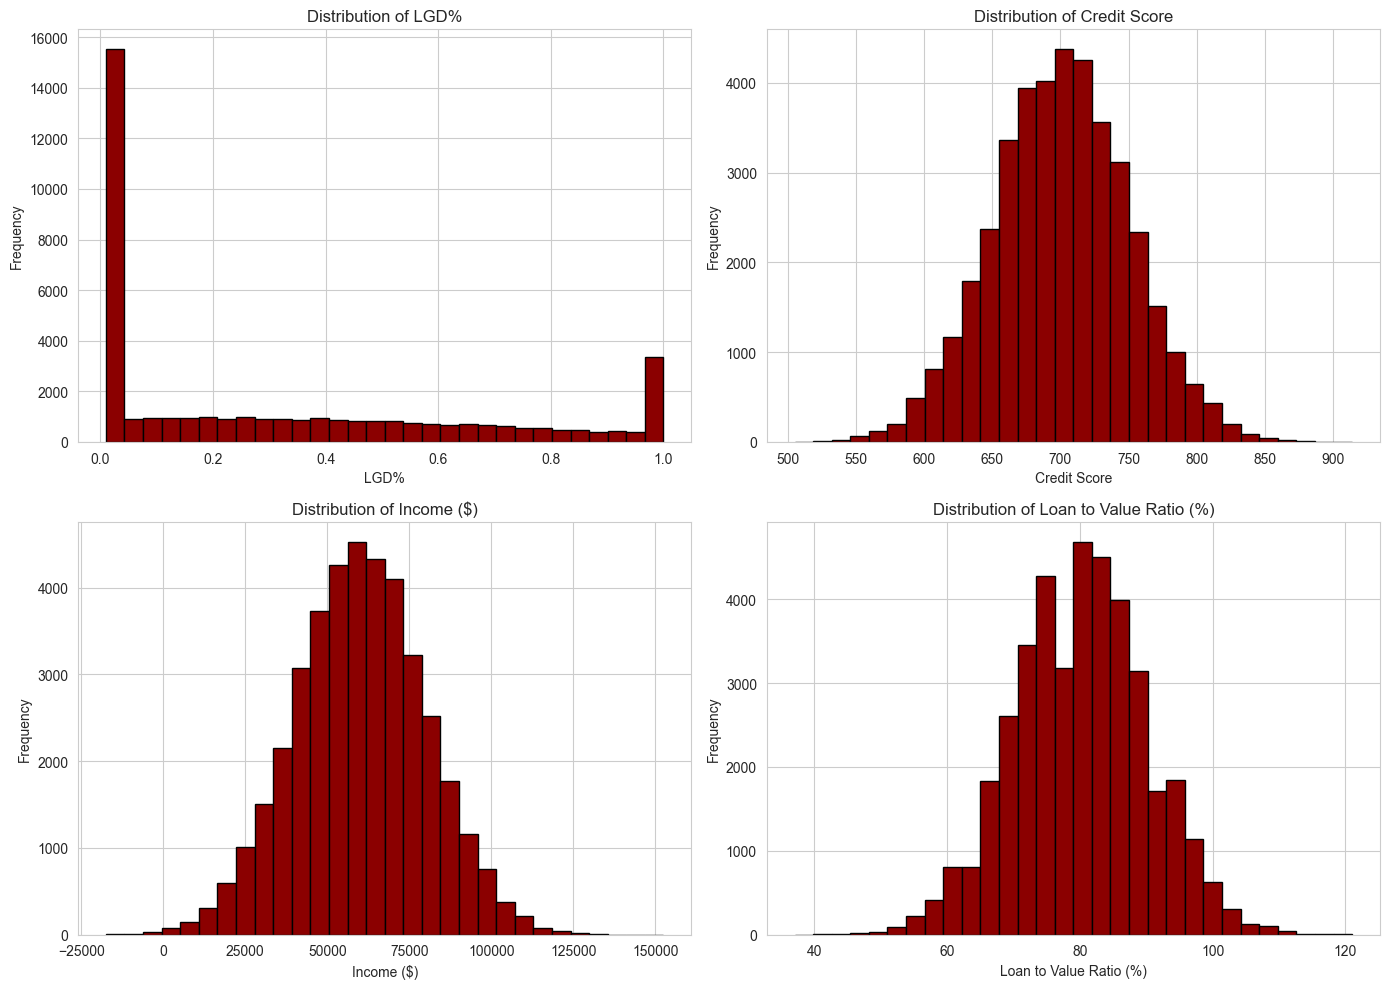

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plot_cols = ["LGD%", "Credit Score", "Income ($)", "Loan to Value Ratio (%)"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(plot_cols):
    df[col].hist(bins=30, ax=axes[i], color="#8B0000", edgecolor="black")
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


Correlation Heatmap of Numeric Features 

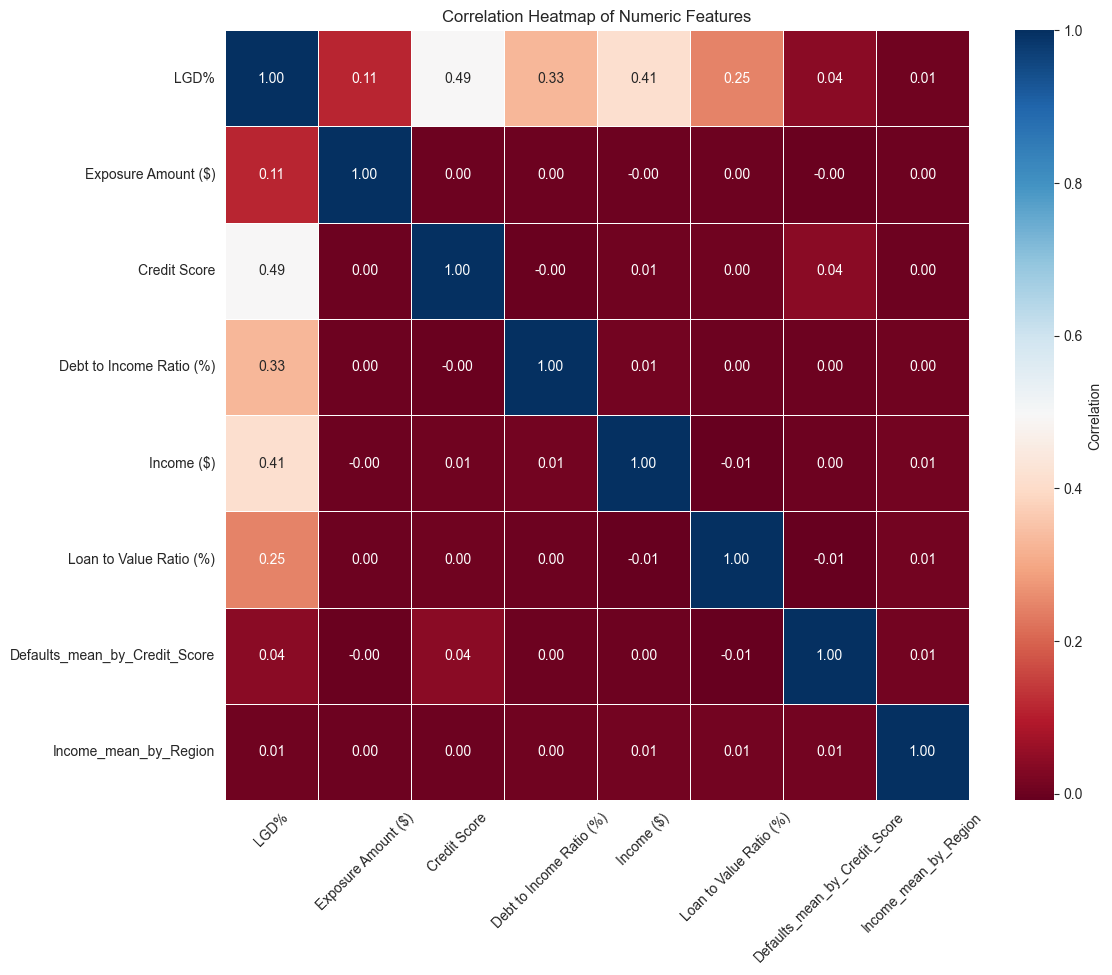

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = [
    "LGD%",
    "Exposure Amount ($)",
    "Credit Score",
    "Debt to Income Ratio (%)",
    "Income ($)",
    "Loan to Value Ratio (%)",
    "Defaults_mean_by_Credit_Score",
    "Income_mean_by_Region"
]

corr = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="RdBu",
    linewidths=0.5,
    cbar_kws={"label": "Correlation"}
)

plt.title("Correlation Heatmap of Numeric Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


Distribution of Categorical Features 

/var/folders/m3/kyg1q9bd15jd378c999hmcfr0000gn/T/ipykernel_11235/677794197.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, ax=ax, palette="Blues")
/var/folders/m3/kyg1q9bd15jd378c999hmcfr0000gn/T/ipykernel_11235/677794197.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, ax=ax, palette="Blues")
/var/folders/m3/kyg1q9bd15jd378c999hmcfr0000gn/T/ipykernel_11235/677794197.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, ax=ax, palette="Blues")
/var/folders/m3/kyg1q9bd15jd378c999hm

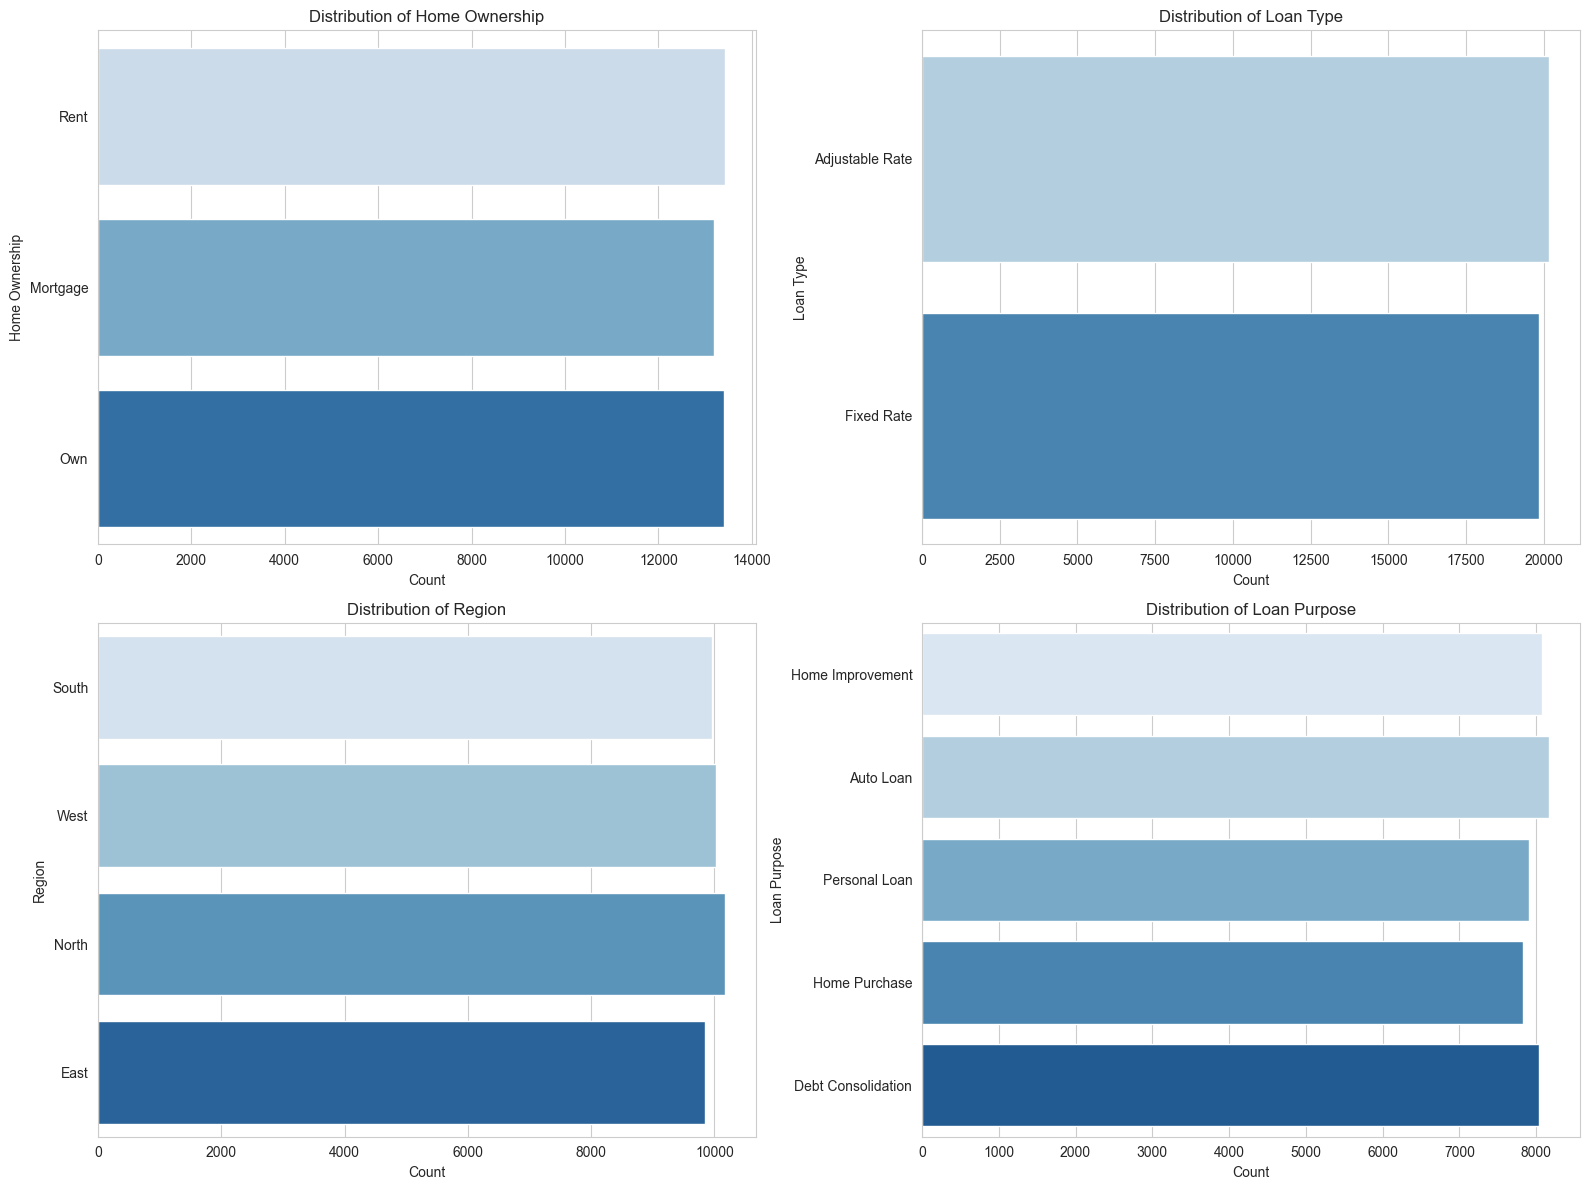

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

cat_cols = ["Home Ownership", "Loan Type", "Region", "Loan Purpose"]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, col in zip(axes, cat_cols):
    sns.countplot(y=col, data=df, ax=ax, palette="Blues")
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel("Count")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()



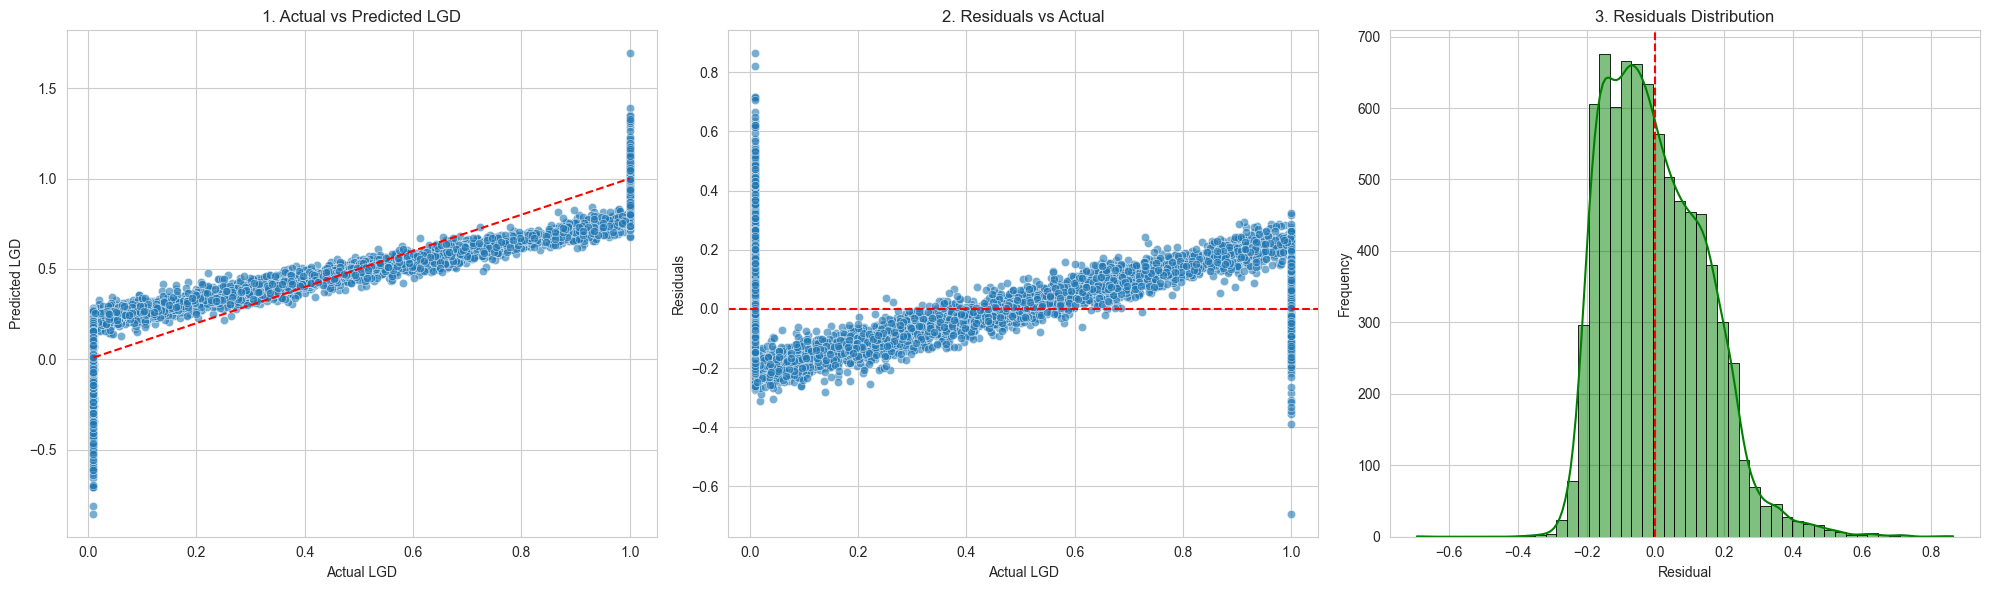

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")

results_df = pd.DataFrame({
    'Actual LGD': y_test,
    'Predicted LGD': y_test_pred
})
results_df['Residuals'] = results_df['Actual LGD'] - results_df['Predicted LGD']

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.scatterplot(x='Actual LGD', y='Predicted LGD', data=results_df, ax=axes[0], alpha=0.6)
axes[0].plot([results_df['Actual LGD'].min(), results_df['Actual LGD'].max()],
             [results_df['Actual LGD'].min(), results_df['Actual LGD'].max()],
             linestyle='--', color='red')
axes[0].set_title('1. Actual vs Predicted LGD')
axes[0].set_xlabel('Actual LGD')
axes[0].set_ylabel('Predicted LGD')

sns.scatterplot(x='Actual LGD', y='Residuals', data=results_df, ax=axes[1], alpha=0.6)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('2. Residuals vs Actual')
axes[1].set_xlabel('Actual LGD')
axes[1].set_ylabel('Residuals')

sns.histplot(results_df['Residuals'], bins=50, kde=True, ax=axes[2], color='green', edgecolor='black')
axes[2].axvline(0, color='red', linestyle='--')
axes[2].set_title('3. Residuals Distribution')
axes[2].set_xlabel('Residual')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [28]:
import pandas as pd

metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R²'],
    'Train': [train_mae, train_rmse, train_r2],
    'Test': [test_mae, test_rmse, test_r2]
})

metrics_df[['Train', 'Test']] = metrics_df[['Train', 'Test']].round(5)

print("Model Performance Metrics")
print(metrics_df)




Model Performance Metrics
  Metric    Train     Test
0    MAE  0.11765  0.11814
1   RMSE  0.14430  0.14526
2     R²  0.82139  0.81764


/var/folders/m3/kyg1q9bd15jd378c999hmcfr0000gn/T/ipykernel_11235/822859014.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feat_df.head(20), palette='tab10')


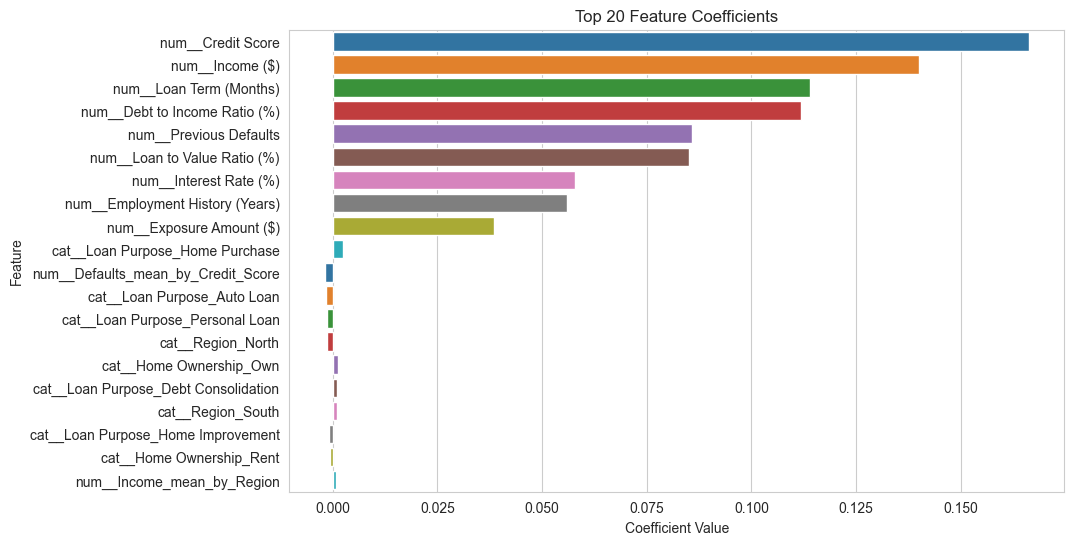

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")

linear_model = model.named_steps['regressor']
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
coefficients = linear_model.coef_

feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

feat_df = feat_df.reindex(feat_df['Coefficient'].abs().sort_values(ascending=False).index)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feat_df.head(20), palette='tab10')
plt.title('Top 20 Feature Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()


Average LGD (%) by Region 

/var/folders/m3/kyg1q9bd15jd378c999hmcfr0000gn/T/ipykernel_11235/778873574.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Region', y='LGD%', data=regional_avg, palette='Reds')


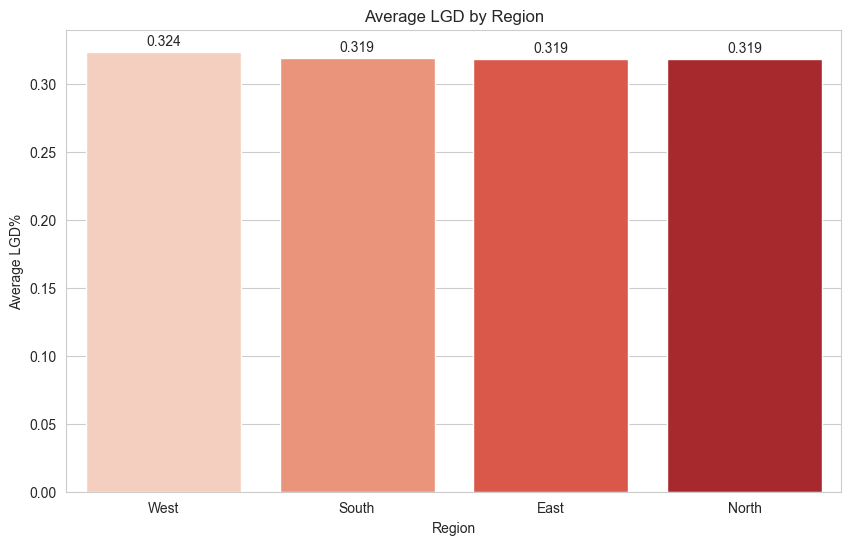

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

regional_avg = df.groupby('Region')['LGD%'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='LGD%', data=regional_avg, palette='Reds')

for i, val in enumerate(regional_avg['LGD%']):
    plt.text(i, val + 0.005, f"{val:.3f}", ha='center')

plt.title('Average LGD by Region')
plt.xlabel('Region')
plt.ylabel('Average LGD%')
plt.show()
